# CNN for classification using pytorch

In this classification, we define and train CNN to classify Fashion_Mnist Database

### Load the data

In [4]:
# import the libraries
import torch
import torchvision

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision import transforms

# the output of torchvision datasets are PILImage of range [0, 1]
# we transform them to tensors for input into CNN

# define a transform to read the data in a tensor
data_transform = transforms.ToTensor()


# choose the training and test datasets
train_data = FashionMNIST(root="./data", train = True, download = True, transform = data_transform)
test_data = FashionMNIST(root="./data", train = False, download = True, transform = data_transform)

# print the stats
print("Train_data, number of images: ", len(train_data))
print("Test_data, number of images: ", len(test_data))

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.6%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



119.3%
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...
Done!
Train_data, number of images:  60000
Test_data, number of images:  10000


In [5]:
# Now the train and test data is defined, we define the dataloader by setting the batch size
batch_size = 20

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle=True)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### visualize the training data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `2 x batch_size/2` grid.

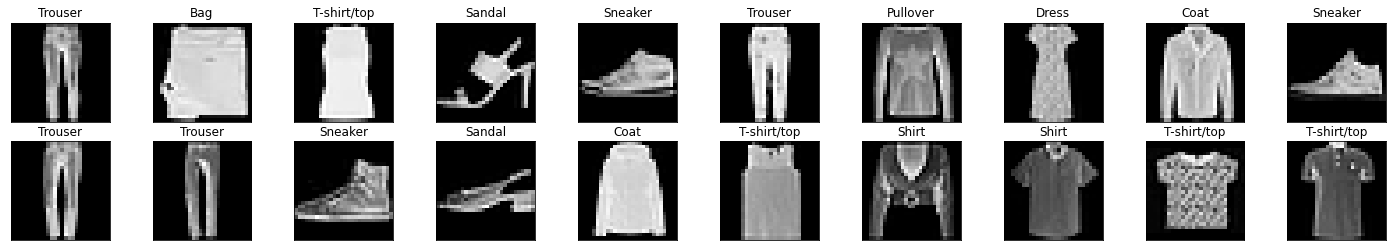

In [7]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# obtain one random batch of training data
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the image in the batch, along with corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

### Define the network architecture

The CNN layers consists of convolutional layers, maxpooling layers, fully-connected layers and dropout layers. 

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        
        # convoultional layers
        self.conv1 = nn.Conv2d(1, 32, 3) # 1 input image channel (gray), 32 feature maps, 3*3 filter kernel
        self.conv2 = nn.Conv2d(32, 64, 3) # 64 feature maps
        
        # maxpooling layers
        self.pool1 = nn.MaxPool2d(2, 2) # 2x2 kernel, stride 2
        
        # fully connected layer
        self.fc1 = nn.Linear(64 * 5 * 5, 128) # downsampled image size after pooling
        self.fc2 = nn.Linear(128, 10)
        
        # dropout layer
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        
        # max pooling of first activated conv layer 
        x = self.pool1(F.relu(self.conv1(x)))
        
        # max pooling of second activated conv layer 
        x = self.pool1(F.relu(self.conv2(x)))
        
        # prep for linear layer by flattening feature maps into feature vectors
        x = x.view(x.size(0), -1)
        # x = self.dropout(x)
        
        # first linear layer
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        # second linear layer
        x = F.relu(self.fc2(x))
        
        # final output
        return x

# instantiate and print Net
net = Net()
print(net)
        

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Specify the loss function and optimizer

In [30]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimzer
optimizer = optim.SGD(net.parameters(), lr = 0.01)

### Accuracy

In [27]:

# calculate accuracy before training
correct  = 0
total = 0

# iterate through test dataset
for images, labels in test_loader:
    
    # forward pass to get outputs, outputs are series of class scores
    outputs = net(images)
    
    # get the predicted class from max-val in output list from class scores
    _, predicted = torch.max(outputs.data, 1)
    
    
    # count total no. of correct labels for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
# calculate the accuracy
accuracy = 100 * correct/total


# print the accuracy
print("Accuracy before training: ", accuracy)

Accuracy before training:  tensor(7.8800)


### Train the network

In [33]:
def train(n_epochs):
    
    # loop over the datasets n_epochs times
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):
            
            # get the input images and thier labels
            inputs, labels = data
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward pass to get outputs
            outputs = net(inputs)
            
            # calculate the loss
            loss = criterion(outputs, labels)
            
            # backward pass to calculate param gradients
            loss.backward()
            
            # update the parameters
            optimizer.step()
            
            # print loss statistics
            running_loss += loss.data
            if batch_i % 1000 == 999:    # print every 1000 mini_batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i + 1, running_loss/1000))
                running_loss = 0.0
    
    print('Finished Training')

In [34]:
# define the no. of epochs to train for
n_epochs = 5 # start small to see if omdel works, initially

# call train
train(n_epochs)

Epoch: 1, Batch: 1000, Avg. Loss: 1.9476561546325684
Epoch: 1, Batch: 2000, Avg. Loss: 0.9683239459991455
Epoch: 1, Batch: 3000, Avg. Loss: 0.7390673160552979
Epoch: 2, Batch: 1000, Avg. Loss: 0.6463654637336731
Epoch: 2, Batch: 2000, Avg. Loss: 0.5931143760681152
Epoch: 2, Batch: 3000, Avg. Loss: 0.5690725445747375
Epoch: 3, Batch: 1000, Avg. Loss: 0.5327831506729126
Epoch: 3, Batch: 2000, Avg. Loss: 0.5095341205596924
Epoch: 3, Batch: 3000, Avg. Loss: 0.48394766449928284
Epoch: 4, Batch: 1000, Avg. Loss: 0.47083431482315063
Epoch: 4, Batch: 2000, Avg. Loss: 0.4488646984100342
Epoch: 4, Batch: 3000, Avg. Loss: 0.4380732476711273
Epoch: 5, Batch: 1000, Avg. Loss: 0.4247637689113617
Epoch: 5, Batch: 2000, Avg. Loss: 0.42338475584983826
Epoch: 5, Batch: 3000, Avg. Loss: 0.40782099962234497
Finished Training


### Test the trained network

In [38]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss = torch.zeros(1)
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# se the module to evaluation mode
net.eval()

for batch_i, data in enumerate(test_loader):
    
    # get the input image and their corresponding labels
    inputs, labels = data
    
    # forward pass to get outputs
    outputs = net(inputs)
    
    # calculate loss
    loss = criterion(outputs, labels)
    
    # update average test loss
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data - test_loss))
    
    # get the predicted class from max_val in output list
    _, predicted = torch.max(outputs.data, 1)
    
    # compare predictions to true label
    correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test accuracy of %5s: N/A (no training examples)' % (classes[i]))


print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

        

Test Loss: 0.403871

Test accuracy of T-shirt/top: 83% (831/1000)
Test accuracy of Trouser: 96% (968/1000)
Test accuracy of Pullover: 71% (716/1000)
Test accuracy of Dress: 84% (844/1000)
Test accuracy of  Coat: 85% (850/1000)
Test accuracy of Sandal: 96% (960/1000)
Test accuracy of Shirt: 51% (516/1000)
Test accuracy of Sneaker: 90% (901/1000)
Test accuracy of   Bag: 95% (958/1000)
Test accuracy of Ankle boot: 96% (961/1000)

Test Accuracy (Overall): 85% (8505/10000)


### Visualize sample test results

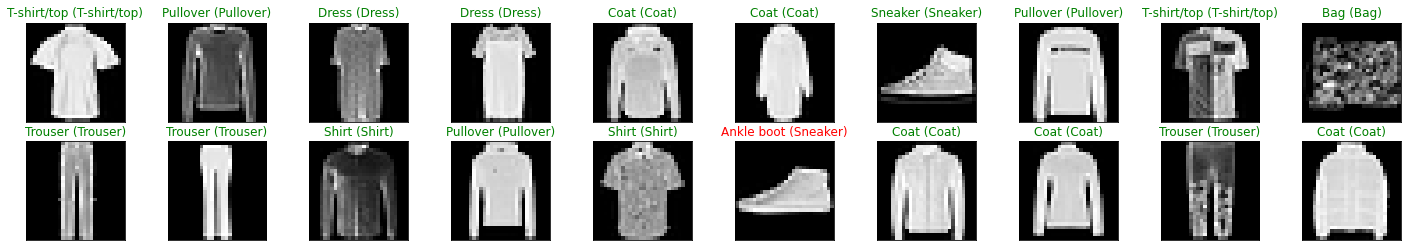

In [41]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get predictions
preds = np.squeeze(net(images).data.max(1, keepdim=True)[1].numpy())
images = images.numpy()

# plo thte images in the batch, along with predicted and true model
fig = plt.figure(figsize = (25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                color=("green" if preds[idx] == labels[idx] else "red"))
    

### Save the trained model

In [44]:
model_dir = 'saved_models/'
model_name = 'model_1.pt'

# save the model parameters in the directory
torch.save(net.state_dict(), model_dir + model_name)

### Load the trained model

In [45]:
# instantiate the net class
net = Net()

# laod the parameters of saved model
net.load_state_dict(torch.load('saved_models/model_1.pt'))

print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
